# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = gym.make('BipedalWalker-v2')

random_seed = 10
env.seed(random_seed)

# from agent import Agent
# agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], 
#               random_seed=random_seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


[10]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
env.action_space, env.observation_space

(Box(4,), Box(24,))

In [4]:
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]

In [5]:
action_size, state_size

(4, 24)

In [6]:
env.observation_space.low, env.observation_space.high

(array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf], dtype=float32),
 array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       dtype=float32))

In [7]:
env.action_space.low, env.action_space.high

(array([-1., -1., -1., -1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32))

### 3. Instantiate DDPG Agent

In [8]:
from agent2 import Agent

agent = Agent(s_size=state_size, a_size=action_size, random_seed=random_seed)

### 4. Train the Agent with DDPG

In [18]:
from collections import deque
import numpy as np
import time
import torch

n_episodes=3000

n_steps=10000
n_learn=10
learn_every=20

R_goal=0 # TOCHECK
Rs_deque = deque(maxlen=100)
meanRs = [] # plot

dlosses, glosses, dlosses_Q, dlosses_S = [], [], [], []

In [19]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-bipedal.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-bipedal.pth', map_location='cpu'))

In [ ]:
for i_episode in range(n_episodes):
    
    # # Reset Env
    # env_info = env.reset(train_mode=train_mode)[brain_name]       # reset the environment    
    # S = env_info.vector_observations                   # get the current state (for each agent)
    s = env.reset() # s: state
    #print(s.shape)

    #Rs = np.zeros(num_agents)                            # initialize the score (for each agent)
    R = 0 # R: total reward
    dlosses_, glosses_, dlosses_Q_, dlosses_S_ = [], [], [], []
    
    for i_step in range(n_steps):
    #while True:
        
        a = agent.act(np.reshape(s, [1, -1])) # a=[-1, 1]
        #a *= 2
        #print(a.shape)
        
        # Exploration noise
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)

        # env_info = env.step(A)[brain_name]            # send all actions to the environment
        # S2 = env_info.vector_observations          # get next state (for each agent)
        # rewards = env_info.rewards                          # get reward (for each agent)
        # dones = env_info.local_done                         # see if episode finished
        #s2: next_state, r: reward, done/terminal, env: environment
        s2, r, done, _ = env.step(np.reshape(a, [-1]))
        #print(s2.shape, r, done)


        # for s, a, reward, s2, done in zip(S, A, rewards, S2, dones):
        # agent.step(state, action, reward, next_state, done) # send actions to the agent
        agent.step(s, a, r, s2, done)

        R += r                           # update the score (for each agent)
        s = s2                                # roll over states to next time step

        dlosses__, glosses__, dlosses_Q__, dlosses_S__ = [], [], [], []
        if i_step%learn_every == 0:
            for _ in range(n_learn):
                dloss, gloss, dloss_Q, dloss_S = agent.start_learn()
                dlosses__.append(dloss)
                glosses__.append(gloss)
                dlosses_Q__.append(dloss_Q)
                dlosses_S__.append(dloss_S)
            dlosses_.append(np.mean(dlosses__))
            glosses_.append(np.mean(glosses__))
            dlosses_Q_.append(np.mean(dlosses_Q__))
            dlosses_S_.append(np.mean(dlosses_S__))
            
        # print(len(agent.memory))
        # agent.start_learn()

        # if np.any(dones):                                   # exit loop if episode finished
        #     break
        if done:
            break

    #meanR = np.mean(Rs)
    #Rs_deque.append(meanR)
    Rs_deque.append(R)
    meanRs.append(np.mean(Rs_deque)) # plot
    
    dlosses.append(np.mean(dlosses_))
    glosses.append(np.mean(glosses_))
    dlosses_Q.append(np.mean(dlosses_Q_))
    dlosses_S.append(np.mean(dlosses_S_))

    print('\rEpisode {}\tTotal Average Score: {:.2f}\tGloss: {:.2f}\tDloss: {:.2f}\tDlossQ: {:.2f}\tDlossS: {:.2f}'.format(
            i_episode+1, np.mean(Rs_deque), np.mean(glosses_), np.mean(dlosses_), np.mean(dlosses_Q_), np.mean(dlosses_S_)))
    
    if np.mean(Rs_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-bipedal.pth')
        torch.save(agent.d.state_dict(), 'd-bipedal.pth')
        break

Episode 1	Total Average Score: -25.27	Gloss: -0.05	Dloss: 51.41	DlossQ: 51.29	DlossS: 0.12
Episode 2	Total Average Score: -73.95	Gloss: -0.05	Dloss: 48.82	DlossQ: 48.70	DlossS: 0.12
Episode 3	Total Average Score: -81.31	Gloss: -0.05	Dloss: 44.33	DlossQ: 44.20	DlossS: 0.12
Episode 4	Total Average Score: -85.20	Gloss: -0.05	Dloss: 52.68	DlossQ: 52.56	DlossS: 0.12
Episode 5	Total Average Score: -87.42	Gloss: -0.05	Dloss: 51.76	DlossQ: 51.63	DlossS: 0.12
Episode 6	Total Average Score: -88.84	Gloss: -0.05	Dloss: 46.28	DlossQ: 46.16	DlossS: 0.12
Episode 7	Total Average Score: -89.97	Gloss: -0.05	Dloss: 52.34	DlossQ: 52.22	DlossS: 0.12
Episode 8	Total Average Score: -90.68	Gloss: -0.05	Dloss: 50.48	DlossQ: 50.36	DlossS: 0.12
Episode 9	Total Average Score: -93.47	Gloss: -0.05	Dloss: 51.95	DlossQ: 51.83	DlossS: 0.12
Episode 10	Total Average Score: -93.74	Gloss: -0.05	Dloss: 52.15	DlossQ: 52.02	DlossS: 0.12
Episode 11	Total Average Score: -94.02	Gloss: -0.05	Dloss: 53.09	DlossQ: 52.97	DlossS: 0.

Episode 91	Total Average Score: -97.64	Gloss: -0.04	Dloss: 52.68	DlossQ: 52.56	DlossS: 0.12
Episode 92	Total Average Score: -97.62	Gloss: -0.04	Dloss: 48.62	DlossQ: 48.50	DlossS: 0.12
Episode 93	Total Average Score: -97.62	Gloss: -0.04	Dloss: 47.30	DlossQ: 47.18	DlossS: 0.12
Episode 94	Total Average Score: -97.61	Gloss: -0.04	Dloss: 50.48	DlossQ: 50.36	DlossS: 0.12
Episode 95	Total Average Score: -97.65	Gloss: -0.04	Dloss: 51.11	DlossQ: 50.99	DlossS: 0.12
Episode 96	Total Average Score: -97.65	Gloss: -0.04	Dloss: 43.64	DlossQ: 43.52	DlossS: 0.12
Episode 97	Total Average Score: -97.63	Gloss: -0.04	Dloss: 52.93	DlossQ: 52.80	DlossS: 0.12
Episode 98	Total Average Score: -97.62	Gloss: -0.04	Dloss: 48.20	DlossQ: 48.08	DlossS: 0.12
Episode 99	Total Average Score: -97.62	Gloss: -0.04	Dloss: 52.76	DlossQ: 52.64	DlossS: 0.12
Episode 100	Total Average Score: -97.64	Gloss: -0.04	Dloss: 48.28	DlossQ: 48.16	DlossS: 0.12
Episode 101	Total Average Score: -98.39	Gloss: -0.04	Dloss: 45.76	DlossQ: 45.64

Episode 180	Total Average Score: -99.01	Gloss: -0.04	Dloss: 50.48	DlossQ: 50.36	DlossS: 0.12
Episode 181	Total Average Score: -99.00	Gloss: -0.04	Dloss: 54.01	DlossQ: 53.89	DlossS: 0.12
Episode 182	Total Average Score: -99.02	Gloss: -0.04	Dloss: 50.38	DlossQ: 50.26	DlossS: 0.12
Episode 183	Total Average Score: -99.47	Gloss: -0.04	Dloss: 54.63	DlossQ: 54.51	DlossS: 0.12
Episode 184	Total Average Score: -99.49	Gloss: -0.04	Dloss: 56.35	DlossQ: 56.22	DlossS: 0.12
Episode 185	Total Average Score: -99.51	Gloss: -0.04	Dloss: 57.42	DlossQ: 57.30	DlossS: 0.12
Episode 186	Total Average Score: -99.55	Gloss: -0.04	Dloss: 51.75	DlossQ: 51.63	DlossS: 0.12
Episode 187	Total Average Score: -99.64	Gloss: -0.04	Dloss: 57.81	DlossQ: 57.69	DlossS: 0.12
Episode 188	Total Average Score: -99.63	Gloss: -0.04	Dloss: 54.88	DlossQ: 54.76	DlossS: 0.12
Episode 189	Total Average Score: -99.65	Gloss: -0.04	Dloss: 51.70	DlossQ: 51.58	DlossS: 0.12
Episode 190	Total Average Score: -99.67	Gloss: -0.04	Dloss: 51.75	Dlos

Episode 268	Total Average Score: -103.09	Gloss: -0.04	Dloss: 55.12	DlossQ: 55.00	DlossS: 0.12
Episode 269	Total Average Score: -103.15	Gloss: -0.04	Dloss: 55.85	DlossQ: 55.74	DlossS: 0.12
Episode 270	Total Average Score: -103.01	Gloss: -0.04	Dloss: 49.01	DlossQ: 48.89	DlossS: 0.12
Episode 271	Total Average Score: -103.01	Gloss: -0.04	Dloss: 58.01	DlossQ: 57.89	DlossS: 0.12
Episode 272	Total Average Score: -103.00	Gloss: -0.04	Dloss: 48.82	DlossQ: 48.70	DlossS: 0.12
Episode 273	Total Average Score: -103.09	Gloss: -0.04	Dloss: 55.86	DlossQ: 55.74	DlossS: 0.12
Episode 274	Total Average Score: -103.10	Gloss: -0.04	Dloss: 51.70	DlossQ: 51.58	DlossS: 0.12
Episode 275	Total Average Score: -103.23	Gloss: -0.04	Dloss: 54.88	DlossQ: 54.76	DlossS: 0.12
Episode 276	Total Average Score: -103.20	Gloss: -0.04	Dloss: 48.43	DlossQ: 48.31	DlossS: 0.12
Episode 277	Total Average Score: -103.19	Gloss: -0.04	Dloss: 54.63	DlossQ: 54.51	DlossS: 0.12
Episode 278	Total Average Score: -103.22	Gloss: -0.04	Dloss:

Episode 356	Total Average Score: -103.38	Gloss: -0.04	Dloss: 51.70	DlossQ: 51.58	DlossS: 0.12
Episode 357	Total Average Score: -103.24	Gloss: -0.04	Dloss: 57.08	DlossQ: 56.96	DlossS: 0.12
Episode 358	Total Average Score: -103.10	Gloss: -0.04	Dloss: 57.81	DlossQ: 57.69	DlossS: 0.12
Episode 359	Total Average Score: -103.12	Gloss: -0.04	Dloss: 54.88	DlossQ: 54.76	DlossS: 0.12
Episode 360	Total Average Score: -103.12	Gloss: -0.04	Dloss: 56.83	DlossQ: 56.71	DlossS: 0.12
Episode 361	Total Average Score: -103.11	Gloss: -0.04	Dloss: 59.52	DlossQ: 59.40	DlossS: 0.12
Episode 362	Total Average Score: -103.24	Gloss: -0.04	Dloss: 52.68	DlossQ: 52.56	DlossS: 0.12
Episode 363	Total Average Score: -103.24	Gloss: -0.04	Dloss: 56.84	DlossQ: 56.71	DlossS: 0.12
Episode 364	Total Average Score: -103.26	Gloss: -0.04	Dloss: 60.74	DlossQ: 60.62	DlossS: 0.12
Episode 365	Total Average Score: -103.14	Gloss: -0.04	Dloss: 53.17	DlossQ: 53.05	DlossS: 0.12
Episode 366	Total Average Score: -103.19	Gloss: -0.04	Dloss:

Episode 444	Total Average Score: -104.99	Gloss: -0.04	Dloss: 60.01	DlossQ: 59.89	DlossS: 0.12
Episode 445	Total Average Score: -105.00	Gloss: -0.04	Dloss: 63.09	DlossQ: 62.97	DlossS: 0.12
Episode 446	Total Average Score: -105.02	Gloss: -0.04	Dloss: 57.33	DlossQ: 57.20	DlossS: 0.12
Episode 447	Total Average Score: -105.04	Gloss: -0.04	Dloss: 53.71	DlossQ: 53.59	DlossS: 0.12
Episode 448	Total Average Score: -105.14	Gloss: -0.04	Dloss: 62.21	DlossQ: 62.09	DlossS: 0.12
Episode 449	Total Average Score: -105.13	Gloss: -0.04	Dloss: 54.88	DlossQ: 54.76	DlossS: 0.12
Episode 450	Total Average Score: -105.14	Gloss: -0.04	Dloss: 62.11	DlossQ: 61.99	DlossS: 0.12
Episode 451	Total Average Score: -105.30	Gloss: -0.04	Dloss: 57.25	DlossQ: 57.13	DlossS: 0.12
Episode 452	Total Average Score: -105.42	Gloss: -0.04	Dloss: 56.10	DlossQ: 55.98	DlossS: 0.12
Episode 453	Total Average Score: -105.42	Gloss: -0.04	Dloss: 63.44	DlossQ: 63.31	DlossS: 0.12
Episode 454	Total Average Score: -105.55	Gloss: -0.04	Dloss:

Episode 532	Total Average Score: -106.12	Gloss: -0.04	Dloss: 52.19	DlossQ: 52.07	DlossS: 0.12
Episode 533	Total Average Score: -106.13	Gloss: -0.04	Dloss: 67.20	DlossQ: 67.07	DlossS: 0.12
Episode 534	Total Average Score: -106.27	Gloss: -0.04	Dloss: 62.21	DlossQ: 62.09	DlossS: 0.12
Episode 535	Total Average Score: -106.34	Gloss: -0.04	Dloss: 61.23	DlossQ: 61.11	DlossS: 0.12
Episode 536	Total Average Score: -106.34	Gloss: -0.04	Dloss: 57.81	DlossQ: 57.69	DlossS: 0.12
Episode 537	Total Average Score: -106.36	Gloss: -0.04	Dloss: 54.88	DlossQ: 54.76	DlossS: 0.12
Episode 538	Total Average Score: -106.37	Gloss: -0.04	Dloss: 61.72	DlossQ: 61.60	DlossS: 0.12
Episode 539	Total Average Score: -106.37	Gloss: -0.04	Dloss: 60.75	DlossQ: 60.62	DlossS: 0.12
Episode 540	Total Average Score: -106.47	Gloss: -0.04	Dloss: 57.57	DlossQ: 57.45	DlossS: 0.12
Episode 541	Total Average Score: -106.47	Gloss: -0.04	Dloss: 64.66	DlossQ: 64.53	DlossS: 0.12
Episode 542	Total Average Score: -106.57	Gloss: -0.04	Dloss:

Episode 620	Total Average Score: -105.78	Gloss: -0.04	Dloss: 54.07	DlossQ: 53.95	DlossS: 0.12
Episode 621	Total Average Score: -105.79	Gloss: -0.04	Dloss: 60.94	DlossQ: 60.82	DlossS: 0.12
Episode 622	Total Average Score: -105.64	Gloss: -0.04	Dloss: 61.72	DlossQ: 61.60	DlossS: 0.12
Episode 623	Total Average Score: -105.50	Gloss: -0.04	Dloss: 62.95	DlossQ: 62.82	DlossS: 0.12
Episode 624	Total Average Score: -105.62	Gloss: -0.04	Dloss: 65.82	DlossQ: 65.71	DlossS: 0.12
Episode 625	Total Average Score: -105.60	Gloss: -0.04	Dloss: 57.81	DlossQ: 57.69	DlossS: 0.12
Episode 626	Total Average Score: -105.73	Gloss: -0.04	Dloss: 63.51	DlossQ: 63.39	DlossS: 0.12
Episode 627	Total Average Score: -105.72	Gloss: -0.04	Dloss: 62.05	DlossQ: 61.93	DlossS: 0.12
Episode 628	Total Average Score: -105.59	Gloss: -0.04	Dloss: 69.78	DlossQ: 69.66	DlossS: 0.12
Episode 629	Total Average Score: -105.47	Gloss: -0.04	Dloss: 60.01	DlossQ: 59.89	DlossS: 0.12
Episode 630	Total Average Score: -105.34	Gloss: -0.04	Dloss:

Episode 708	Total Average Score: -101.58	Gloss: -0.04	Dloss: 63.92	DlossQ: 63.80	DlossS: 0.12
Episode 709	Total Average Score: -101.58	Gloss: -0.04	Dloss: 64.41	DlossQ: 64.29	DlossS: 0.12
Episode 710	Total Average Score: -101.58	Gloss: -0.04	Dloss: 64.27	DlossQ: 64.14	DlossS: 0.12
Episode 711	Total Average Score: -101.61	Gloss: -0.04	Dloss: 67.59	DlossQ: 67.47	DlossS: 0.12
Episode 712	Total Average Score: -101.73	Gloss: -0.04	Dloss: 63.49	DlossQ: 63.36	DlossS: 0.13
Episode 713	Total Average Score: -101.60	Gloss: -0.04	Dloss: 63.19	DlossQ: 63.07	DlossS: 0.12
Episode 714	Total Average Score: -101.74	Gloss: -0.04	Dloss: 59.93	DlossQ: 59.81	DlossS: 0.12
Episode 715	Total Average Score: -101.62	Gloss: -0.04	Dloss: 61.14	DlossQ: 61.02	DlossS: 0.12
Episode 716	Total Average Score: -101.63	Gloss: -0.04	Dloss: 61.72	DlossQ: 61.60	DlossS: 0.12
Episode 717	Total Average Score: -101.50	Gloss: -0.04	Dloss: 60.75	DlossQ: 60.63	DlossS: 0.12
Episode 718	Total Average Score: -101.61	Gloss: -0.04	Dloss:

Episode 796	Total Average Score: -106.06	Gloss: -0.04	Dloss: 63.68	DlossQ: 63.56	DlossS: 0.12
Episode 797	Total Average Score: -106.11	Gloss: -0.04	Dloss: 67.83	DlossQ: 67.71	DlossS: 0.12
Episode 798	Total Average Score: -106.04	Gloss: -0.04	Dloss: 62.46	DlossQ: 62.34	DlossS: 0.12
Episode 799	Total Average Score: -106.04	Gloss: -0.04	Dloss: 72.23	DlossQ: 72.11	DlossS: 0.12
Episode 800	Total Average Score: -106.04	Gloss: -0.04	Dloss: 61.72	DlossQ: 61.60	DlossS: 0.12
Episode 801	Total Average Score: -106.20	Gloss: -0.04	Dloss: 65.14	DlossQ: 65.02	DlossS: 0.12
Episode 802	Total Average Score: -106.29	Gloss: -0.04	Dloss: 68.24	DlossQ: 68.12	DlossS: 0.12
Episode 803	Total Average Score: -106.22	Gloss: -0.04	Dloss: 67.71	DlossQ: 67.59	DlossS: 0.12
Episode 804	Total Average Score: -106.29	Gloss: -0.04	Dloss: 62.42	DlossQ: 62.30	DlossS: 0.12
Episode 805	Total Average Score: -106.28	Gloss: -0.04	Dloss: 67.59	DlossQ: 67.47	DlossS: 0.12
Episode 806	Total Average Score: -106.29	Gloss: -0.04	Dloss:

Episode 884	Total Average Score: -107.51	Gloss: -0.04	Dloss: 60.50	DlossQ: 60.38	DlossS: 0.12
Episode 885	Total Average Score: -107.42	Gloss: -0.04	Dloss: 66.12	DlossQ: 66.00	DlossS: 0.12
Episode 886	Total Average Score: -107.41	Gloss: -0.04	Dloss: 66.61	DlossQ: 66.49	DlossS: 0.12
Episode 887	Total Average Score: -107.19	Gloss: -0.04	Dloss: 65.63	DlossQ: 65.51	DlossS: 0.12
Episode 888	Total Average Score: -107.33	Gloss: -0.04	Dloss: 67.00	DlossQ: 66.88	DlossS: 0.12
Episode 889	Total Average Score: -107.31	Gloss: -0.04	Dloss: 67.20	DlossQ: 67.07	DlossS: 0.12
Episode 890	Total Average Score: -107.36	Gloss: -0.04	Dloss: 67.37	DlossQ: 67.25	DlossS: 0.12
Episode 891	Total Average Score: -107.41	Gloss: -0.04	Dloss: 67.31	DlossQ: 67.19	DlossS: 0.12
Episode 892	Total Average Score: -107.24	Gloss: -0.04	Dloss: 69.44	DlossQ: 69.31	DlossS: 0.12
Episode 893	Total Average Score: -107.16	Gloss: -0.04	Dloss: 68.76	DlossQ: 68.64	DlossS: 0.12
Episode 894	Total Average Score: -107.17	Gloss: -0.04	Dloss:

Episode 972	Total Average Score: -106.80	Gloss: -0.04	Dloss: 68.03	DlossQ: 67.91	DlossS: 0.12
Episode 973	Total Average Score: -106.81	Gloss: -0.04	Dloss: 66.80	DlossQ: 66.68	DlossS: 0.12
Episode 974	Total Average Score: -106.82	Gloss: -0.04	Dloss: 64.85	DlossQ: 64.73	DlossS: 0.12
Episode 975	Total Average Score: -106.81	Gloss: -0.04	Dloss: 62.31	DlossQ: 62.19	DlossS: 0.12
Episode 976	Total Average Score: -106.81	Gloss: -0.04	Dloss: 66.24	DlossQ: 66.12	DlossS: 0.12
Episode 977	Total Average Score: -106.78	Gloss: -0.04	Dloss: 64.26	DlossQ: 64.14	DlossS: 0.12
Episode 978	Total Average Score: -106.65	Gloss: -0.04	Dloss: 62.45	DlossQ: 62.33	DlossS: 0.12
Episode 979	Total Average Score: -106.79	Gloss: -0.04	Dloss: 66.61	DlossQ: 66.49	DlossS: 0.12
Episode 980	Total Average Score: -107.00	Gloss: -0.04	Dloss: 66.02	DlossQ: 65.90	DlossS: 0.12
Episode 981	Total Average Score: -107.07	Gloss: -0.04	Dloss: 67.98	DlossQ: 67.86	DlossS: 0.12
Episode 982	Total Average Score: -106.90	Gloss: -0.04	Dloss:

Episode 1059	Total Average Score: -105.39	Gloss: -0.04	Dloss: 62.70	DlossQ: 62.58	DlossS: 0.12
Episode 1060	Total Average Score: -105.55	Gloss: -0.04	Dloss: 74.62	DlossQ: 74.50	DlossS: 0.12
Episode 1061	Total Average Score: -105.40	Gloss: -0.04	Dloss: 70.24	DlossQ: 70.12	DlossS: 0.12
Episode 1062	Total Average Score: -105.33	Gloss: -0.04	Dloss: 64.33	DlossQ: 64.21	DlossS: 0.12
Episode 1063	Total Average Score: -105.41	Gloss: -0.04	Dloss: 71.50	DlossQ: 71.38	DlossS: 0.12
Episode 1064	Total Average Score: -105.26	Gloss: -0.04	Dloss: 67.98	DlossQ: 67.86	DlossS: 0.12
Episode 1065	Total Average Score: -105.26	Gloss: -0.04	Dloss: 65.49	DlossQ: 65.37	DlossS: 0.12
Episode 1066	Total Average Score: -105.40	Gloss: -0.04	Dloss: 66.22	DlossQ: 66.10	DlossS: 0.12
Episode 1067	Total Average Score: -105.58	Gloss: -0.04	Dloss: 63.43	DlossQ: 63.31	DlossS: 0.12
Episode 1068	Total Average Score: -105.42	Gloss: -0.04	Dloss: 62.11	DlossQ: 61.99	DlossS: 0.12
Episode 1069	Total Average Score: -105.55	Gloss: -

Episode 1146	Total Average Score: -104.19	Gloss: -0.04	Dloss: 63.09	DlossQ: 62.97	DlossS: 0.12
Episode 1147	Total Average Score: -104.10	Gloss: -0.04	Dloss: 69.62	DlossQ: 69.50	DlossS: 0.12
Episode 1148	Total Average Score: -104.14	Gloss: -0.04	Dloss: 67.31	DlossQ: 67.19	DlossS: 0.12
Episode 1149	Total Average Score: -104.06	Gloss: -0.04	Dloss: 66.20	DlossQ: 66.08	DlossS: 0.12
Episode 1150	Total Average Score: -104.14	Gloss: -0.04	Dloss: 67.58	DlossQ: 67.47	DlossS: 0.12
Episode 1151	Total Average Score: -103.98	Gloss: -0.04	Dloss: 62.38	DlossQ: 62.25	DlossS: 0.12
Episode 1152	Total Average Score: -103.84	Gloss: -0.04	Dloss: 68.57	DlossQ: 68.44	DlossS: 0.12
Episode 1153	Total Average Score: -104.55	Gloss: -0.04	Dloss: 59.28	DlossQ: 59.16	DlossS: 0.12
Episode 1154	Total Average Score: -104.47	Gloss: -0.04	Dloss: 68.40	DlossQ: 68.28	DlossS: 0.12
Episode 1155	Total Average Score: -104.35	Gloss: -0.04	Dloss: 66.22	DlossQ: 66.10	DlossS: 0.12
Episode 1156	Total Average Score: -104.37	Gloss: -

Episode 1233	Total Average Score: -107.50	Gloss: -0.04	Dloss: 66.33	DlossQ: 66.21	DlossS: 0.12
Episode 1234	Total Average Score: -107.77	Gloss: -0.04	Dloss: 68.98	DlossQ: 68.86	DlossS: 0.12
Episode 1235	Total Average Score: -108.10	Gloss: -0.04	Dloss: 69.12	DlossQ: 69.00	DlossS: 0.12
Episode 1236	Total Average Score: -108.43	Gloss: -0.04	Dloss: 66.12	DlossQ: 66.00	DlossS: 0.12
Episode 1237	Total Average Score: -108.68	Gloss: -0.04	Dloss: 66.77	DlossQ: 66.65	DlossS: 0.12
Episode 1238	Total Average Score: -108.54	Gloss: -0.04	Dloss: 72.47	DlossQ: 72.35	DlossS: 0.12
Episode 1239	Total Average Score: -108.82	Gloss: -0.04	Dloss: 62.17	DlossQ: 62.05	DlossS: 0.12
Episode 1240	Total Average Score: -109.08	Gloss: -0.04	Dloss: 66.12	DlossQ: 66.00	DlossS: 0.12
Episode 1241	Total Average Score: -109.29	Gloss: -0.04	Dloss: 69.35	DlossQ: 69.23	DlossS: 0.12
Episode 1242	Total Average Score: -109.43	Gloss: -0.04	Dloss: 71.92	DlossQ: 71.79	DlossS: 0.12
Episode 1243	Total Average Score: -109.74	Gloss: -

Episode 1320	Total Average Score: -112.53	Gloss: -0.05	Dloss: 57.32	DlossQ: 57.20	DlossS: 0.12
Episode 1321	Total Average Score: -112.66	Gloss: -0.05	Dloss: 63.34	DlossQ: 63.23	DlossS: 0.11
Episode 1322	Total Average Score: -112.91	Gloss: -0.05	Dloss: 58.05	DlossQ: 57.94	DlossS: 0.11
Episode 1323	Total Average Score: -113.14	Gloss: -0.05	Dloss: 65.62	DlossQ: 65.51	DlossS: 0.11
Episode 1324	Total Average Score: -113.39	Gloss: -0.05	Dloss: 65.95	DlossQ: 65.84	DlossS: 0.11
Episode 1325	Total Average Score: -113.58	Gloss: -0.05	Dloss: 62.37	DlossQ: 62.25	DlossS: 0.11
Episode 1326	Total Average Score: -113.76	Gloss: -0.05	Dloss: 65.95	DlossQ: 65.84	DlossS: 0.11
Episode 1327	Total Average Score: -114.01	Gloss: -0.05	Dloss: 70.12	DlossQ: 70.01	DlossS: 0.12
Episode 1328	Total Average Score: -113.75	Gloss: -0.05	Dloss: 62.97	DlossQ: 62.86	DlossS: 0.11
Episode 1329	Total Average Score: -114.04	Gloss: -0.05	Dloss: 61.45	DlossQ: 61.33	DlossS: 0.11
Episode 1330	Total Average Score: -113.47	Gloss: -

### 5. Plot the result

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

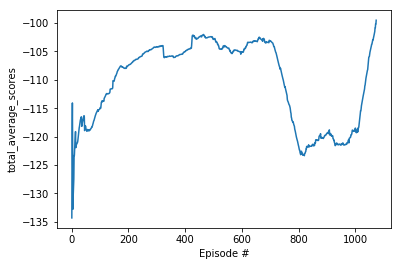

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [36]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-bipedal.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-bipedal.pth', map_location='cpu'))

# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# S = env_info.vector_observations                  # get the current states (S) (for each agent)
s = env.reset() # s: state # get the current state (s) (for an agent)
# print(s.shape)

#Rs = np.zeros(num_agents)                          # initialize the total scores (Rs) (for each agent)
R = 0 # R:total reward # initialize the total score (R) (for an agent)

while True:
    #A = agent.act(S)                        # select actions (A) from loaded model agents
    a = agent.act(np.reshape(s, [1, -1])) # a: [-1, +1]    # select action (a) from loaded model agent
    #a = agent.act(s)
    #print(s.shape, a.shape)
    
    # env_info = env.step(A)[brain_name]           # send all actions (A) to tne environment (env)
    # S2 = env_info.vector_observations         # get next states (S2) (for each agent)
    # rewards = env_info.rewards                         # get rewards (for each agent)
    # dones = env_info.local_done                        # see if the episode is done/finished (terminal)
    s2, r, done, _ = env.step(np.reshape(a, [-1]))
    #s2, r, done = env.step(a)
    
    # Rs += env_info.rewards                         # update the total scores (Rs) (for each agent)
    # S = S2                               # roll over current states (S) to next states (S2)
    R += r # update the total score (R) (for an agent)
    s = s2 # roll over current state (s) to next state (s2)
    
    #if np.any(dones):                                  # exit loop if episode is done/finished
    if done: # exit loop if episode is done/finished (terminal)
        break
        
print('Average of total scores: {}'.format(R))

Average of total scores: -106.75700939138544


When finished, you can close the environment.

In [37]:
env.close()